In [6]:
# Cell 1: All imports
import pandas as pd
import numpy as np
from collections import Counter
from itertools import product
import os

print("✓ All libraries imported!")



✓ All libraries imported!


In [7]:
def generate_kmers(k):
    """Generate all possible k-mers for RNA sequences"""
    bases = ['A', 'U', 'G', 'C']
    kmers = [''.join(p) for p in product(bases, repeat=k)]
    return kmers

# Test it
print(f"Example: For k=3, we have {len(generate_kmers(3))} possible k-mers")
print("First 10 k-mers:", generate_kmers(3)[:10])


Example: For k=3, we have 64 possible k-mers
First 10 k-mers: ['AAA', 'AAU', 'AAG', 'AAC', 'AUA', 'AUU', 'AUG', 'AUC', 'AGA', 'AGU']


In [8]:
def extract_kmer_features(sequence, k=3):
    """Extract k-mer frequency features from an RNA sequence"""
    # Clean sequence
    sequence = sequence.upper().replace('N', '')
    
    # Extract all k-mers
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    
    # Count frequencies
    kmer_counts = Counter(kmers)
    
    return kmer_counts

# Test with a sample sequence
test_seq = "AUGCAUGCAUG"
print(f"Test sequence: {test_seq}")
print(f"3-mer counts: {extract_kmer_features(test_seq, k=3)}")


Test sequence: AUGCAUGCAUG
3-mer counts: Counter({'AUG': 3, 'UGC': 2, 'GCA': 2, 'CAU': 2})


In [9]:
def read_fasta(filename):
    """Read sequences from FASTA file"""
    sequences = {}
    with open(filename, 'r') as f:
        current_id = None
        current_seq = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_id:
                    sequences[current_id] = ''.join(current_seq)
                current_id = line[1:]
                current_seq = []
            else:
                current_seq.append(line)
        if current_id:
            sequences[current_id] = ''.join(current_seq)
    return sequences

# Test loading
print("Testing FASTA file loading...")
# Don't run the full file yet - just check if file exists
import os
print("training.fa exists:", os.path.exists('training.fa'))


Testing FASTA file loading...
training.fa exists: True


In [10]:
def create_kmer_features(sequences, k=3, normalize=True):
    """Create k-mer feature matrix for multiple sequences"""
    all_kmers = generate_kmers(k)
    features = []
    
    for seq_id, sequence in sequences.items():
        kmer_counts = extract_kmer_features(sequence, k)
        
        feature_vector = []
        for kmer in all_kmers:
            count = kmer_counts.get(kmer, 0)
            if normalize:
                count = count / (len(sequence) - k + 1) if len(sequence) >= k else 0
            feature_vector.append(count)
        
        features.append(feature_vector)
    
    df_features = pd.DataFrame(features, 
                                columns=all_kmers,
                                index=list(sequences.keys()))
    
    return df_features

print("Feature extraction function ready!")


Feature extraction function ready!


In [12]:
# Cell 6: Load Training Data (no need for import pandas as pd)
print("Loading training sequences...")
train_sequences = read_fasta('training.fa')
print(f"✓ Loaded {len(train_sequences)} training sequences")

print("Loading training labels...")
train_labels = pd.read_csv('training_class.csv')  # pd is already imported from Cell 1
print(f"✓ Loaded {len(train_labels)} training labels")

# Show first sequence as example
first_id = list(train_sequences.keys())[0]
print(f"\nExample sequence ID: {first_id}")
print(f"Sequence length: {len(train_sequences[first_id])} nucleotides")
print(f"First 50 nucleotides: {train_sequences[first_id][:50]}...")



Loading training sequences...
✓ Loaded 22867 training sequences
Loading training labels...
✓ Loaded 22867 training labels

Example sequence ID: ENSDART00000138379
Sequence length: 2567 nucleotides
First 50 nucleotides: TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAATACGA...


In [13]:
# Cell 7: Extract k-mer features
print("Extracting k-mer features from training data...")
print("This may take a few minutes...")

k = 3  # Start with 3-mers
X_train = create_kmer_features(train_sequences, k=k, normalize=True)

print(f"✓ Feature extraction complete!")
print(f"Feature matrix shape: {X_train.shape}")


Extracting k-mer features from training data...
This may take a few minutes...
✓ Feature extraction complete!
Feature matrix shape: (22867, 64)


In [14]:
# Cell 8: Align Labels with Features
print("Aligning labels with features...")

# Make sure labels match the same sequences as features
y_train = train_labels.set_index('name').loc[X_train.index, 'class']

print(f"✓ Features shape: {X_train.shape}")
print(f"✓ Labels shape: {y_train.shape}")
print(f"\nClass distribution:")
print(y_train.value_counts())
print(f"\n  Class 0 (non-mRNA): {(y_train == 0).sum()} sequences")
print(f"  Class 1 (mRNA):     {(y_train == 1).sum()} sequences")


Aligning labels with features...
✓ Features shape: (22867, 64)
✓ Labels shape: (22867,)

Class distribution:
class
0    14035
1     8832
Name: count, dtype: int64

  Class 0 (non-mRNA): 14035 sequences
  Class 1 (mRNA):     8832 sequences


In [16]:
# Cell 9: Save Features (DO THIS AFTER CELL 8 WORKS)
print("Saving extracted features...")

# Save features and labels
X_train.to_csv('train_kmer_features_k3.csv')
y_train.to_csv('train_labels.csv')

print("✓ Features saved to: train_kmer_features_k3.csv")
print("✓ Labels saved to: train_labels.csv")
print("\nYou can reload them later with:")
print("  X_train = pd.read_csv('train_kmer_features_k3.csv', index_col=0)")
print("  y_train = pd.read_csv('train_labels.csv', index_col=0)['class']")


Saving extracted features...
✓ Features saved to: train_kmer_features_k3.csv
✓ Labels saved to: train_labels.csv

You can reload them later with:
  X_train = pd.read_csv('train_kmer_features_k3.csv', index_col=0)
  y_train = pd.read_csv('train_labels.csv', index_col=0)['class']


In [17]:
# Helper to clean up sequence
IUPAC_ambiguous = set('RYSWKMBDHVN.-')

def preprocess_sequence(sequence):
    sequence = sequence.upper().replace('T', 'U')
    # Replace ambiguous codes with 'N'
    return ''.join(base if base not in IUPAC_ambiguous else 'N' for base in sequence)

# TRY IT OUT
sample = "GCTRYNTGCGGT"
print("Before:", sample)
print("After:", preprocess_sequence(sample))


Before: GCTRYNTGCGGT
After: GCUNNNUGCGGU


In [18]:
def extract_kmer_features_cleaned(sequence, k=3):
    # Preprocess first
    sequence = preprocess_sequence(sequence)
    valid_bases = set('AUGC')
    kmer_counts = Counter()
    valid_kmer_windows = 0

    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        # Only keep k-mers if all letters are A/U/G/C
        if set(kmer) <= valid_bases:
            kmer_counts[kmer] += 1
            valid_kmer_windows += 1
    
    return kmer_counts, valid_kmer_windows

# TRY IT OUT
kmer_counts, valid_window_count = extract_kmer_features_cleaned("GCTRYNTGCGGT", k=3)
print("Counts:", kmer_counts)
print("Valid k-mer windows:", valid_window_count)


Counts: Counter({'GCU': 1, 'UGC': 1, 'GCG': 1, 'CGG': 1, 'GGU': 1})
Valid k-mer windows: 5


In [19]:
# List of all possible k-mers
from itertools import product
def generate_kmers(k):
    return [''.join(p) for p in product('AUGC', repeat=k)]

# Feature extraction on many sequences
def create_kmer_features_cleaned(sequences, k=3):
    all_kmers = generate_kmers(k)
    features = []
    total_valid_windows = []
    
    for seq_id, seq in sequences.items():
        kmer_counts, valid_kmer_count = extract_kmer_features_cleaned(seq, k)
        # Frequencies for each possible k-mer
        if valid_kmer_count == 0:
            feature_vector = [0]*len(all_kmers)
        else:
            feature_vector = [kmer_counts.get(kmer,0)/valid_kmer_count for kmer in all_kmers]
        features.append(feature_vector)
        total_valid_windows.append(valid_kmer_count)
    
    df_features = pd.DataFrame(features, columns=all_kmers, index=list(sequences.keys()))
    return df_features, total_valid_windows

# TRY IT OUT
sequences = {'seq1': 'GCTRYNTGCGGT', 'seq2': 'AUGCAUGCC'}
X_test, valid_windows = create_kmer_features_cleaned(sequences, k=3)
print(X_test)
print("Valid window counts:", valid_windows)


      AAA  AAU  AAG  AAC  AUA  AUU       AUG  AUC  AGA  AGU  ...  CUG  CUC  \
seq1  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ...  0.0  0.0   
seq2  0.0  0.0  0.0  0.0  0.0  0.0  0.285714  0.0  0.0  0.0  ...  0.0  0.0   

      CGA  CGU  CGG  CGC  CCA  CCU  CCG  CCC  
seq1  0.0  0.0  0.2  0.0  0.0  0.0  0.0  0.0  
seq2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 64 columns]
Valid window counts: [5, 7]


In [20]:
# Assume you have read_fasta from before
train_sequences = read_fasta('training.fa')
X_train, valid_windows = create_kmer_features_cleaned(train_sequences, k=3)
print(X_train.shape) # Should match before, but now valid-frequencies


(22867, 64)


In [21]:
X_train.to_csv('train_kmer_features_k3_cleaned.csv')
# If you have labels:
y_train.to_csv('train_labels.csv')


In [22]:
print(X_train.head())
print(X_train.describe())


                         AAA       AAU       AAG       AAC       AUA  \
ENSDART00000138379  0.023831  0.021133  0.019784  0.015737  0.013040   
ENSDART00000075994  0.018786  0.013006  0.023121  0.014451  0.011561   
ENSDART00000153938  0.035849  0.021226  0.024057  0.021698  0.013679   
ENSDART00000152541  0.065992  0.041214  0.023515  0.018963  0.024526   
ENSDART00000139170  0.033000  0.022000  0.030000  0.023000  0.012000   

                         AUU       AUG       AUC       AGA       AGU  ...  \
ENSDART00000138379  0.017986  0.020234  0.016187  0.022482  0.013939  ...   
ENSDART00000075994  0.018786  0.015896  0.021676  0.020231  0.015896  ...   
ENSDART00000153938  0.020283  0.022642  0.017925  0.021226  0.015566  ...   
ENSDART00000152541  0.037674  0.018710  0.016435  0.024526  0.015424  ...   
ENSDART00000139170  0.016000  0.024000  0.012000  0.035000  0.013000  ...   

                         CUG       CUC       CGA       CGU       CGG  \
ENSDART00000138379  0.026978  0.

Matplotlib is building the font cache; this may take a moment.


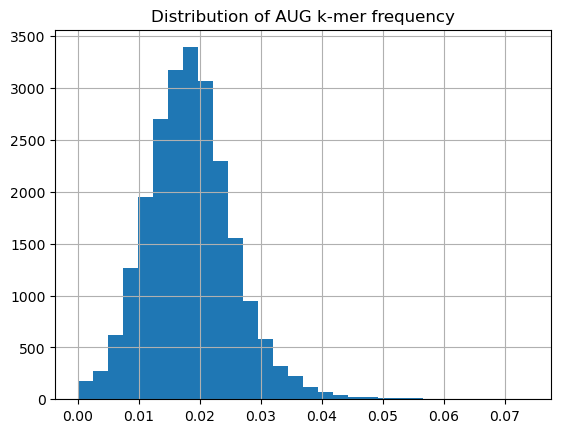

In [23]:
import matplotlib.pyplot as plt
X_train['AUG'].hist(bins=30)
plt.title('Distribution of AUG k-mer frequency')
plt.show()


In [24]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
